# Inductive node classification and representation learning using GraphSAGE


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/graphsage-inductive-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/graphsage-inductive-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook demonstrates inductive representation learning and node classification using the GraphSAGE [1] algorithm applied to inferring the subject of papers in a citation network.

To demonstrate inductive representation learning, we train a GraphSAGE model on a subgraph of the Pubmed-Diabetes citation network. Next, we use the trained model to predict the subject of nodes that were excluded from the subgraph used for model training. 

We remove 20 percent of the network nodes (including all the edges from these nodes to any other nodes in the network) and then train a GraphSAGE model using this network comprised of the remaining 80 percent of nodes. For training, we only use 5 percent of labeled data.

After training the model, we use it to predict the labels, i.e., paper subjects, of the nodes originally held out after re-inserting them in the network. For prediction, we do not retrain the GraphSAGE model.

**References**

[1] Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 [cs.SI], 2017.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the dataset

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
graph_full, labels = dataset.load()

In [5]:
print(graph_full.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]


We aim to train a graph-ML model that will predict the "label" attribute on the nodes. These labels are one of 3 categories:

In [6]:
set(labels)

{1, 2, 3}

We are going to **remove 20 percent of the nodes from the graph**. Then, we are going to train a GraphSAGE model on the reduced graph with the remaining 80 percent of the nodes from the original graph. Later, we are going to re-introduce the removed nodes and try to predict their labels without re-training the GraphSAGE model.

In [7]:
len(labels)

19717

In [8]:
labels_sampled = labels.sample(frac=0.8, replace=False, random_state=101)

`labels_sampled` is a Series that holds the node IDs (the series index) and the associated label of the each of the nodes in the subgraph we are going to use for training the GraphSAGE model.

In [9]:
len(labels_sampled)

15774

Now, we are going to extract the subgraph corresponding to the sampled nodes.

In [10]:
graph_sampled = graph_full.subgraph(labels_sampled.index)

In [11]:
print(graph_sampled.info())

StellarGraph: Undirected multigraph
 Nodes: 15774, Edges: 28852

 Node types:
  paper: [15774]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [28852]


Note above that both the number of nodes and edges have been reduced after removing 20 percent of the nodes in the original graph.

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn to do this.

We are going to use 5 percent of the data for training and of the remaining nodes, we are going to use 20 percent as the validation set. The other 80 percent we can treat as a test set.

In [12]:
train_labels, test_labels = model_selection.train_test_split(
    labels_sampled,
    train_size=0.05,
    test_size=None,
    stratify=labels_sampled,
    random_state=42,
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100,
)

Note using stratified sampling gives the following counts:

In [13]:
from collections import Counter

Counter(train_labels)

Counter({1: 164, 3: 310, 2: 314})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [14]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model we need a generator. The generators are specialized to the model and the learning task so we choose the `GraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-layer model with 10 nodes sampled in the first layer, and 10 in the second.

In [15]:
batch_size = 50
num_samples = [10, 10]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [16]:
generator = GraphSAGENodeGenerator(graph_sampled, batch_size, num_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [17]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [18]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

Now we create a model to predict the 3 categories using Keras softmax layers. Note that we need to use the `G.get_target_size` method to find the number of categories in the data.

In [19]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [20]:
prediction.shape

TensorShape([None, 3])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [21]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [22]:
val_gen = generator.flow(val_labels.index, val_targets)

In [23]:
history = model.fit(
    train_gen, epochs=15, validation_data=val_gen, verbose=0, shuffle=False
)

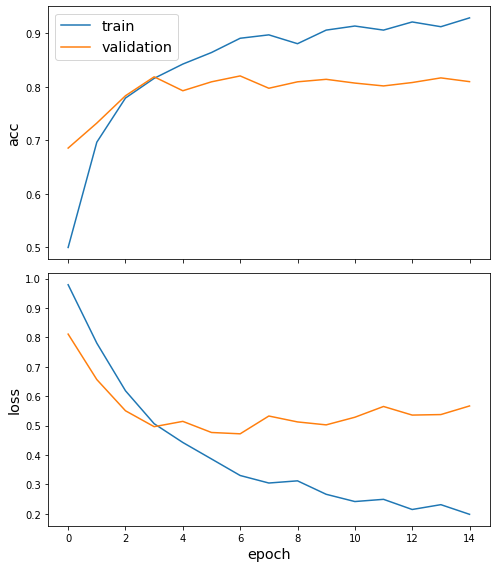

In [24]:
sg.utils.plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [25]:
test_gen = generator.flow(test_labels.index, test_targets)

In [26]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.5591
	acc: 0.8149


### Making predictions with the model

We want to use the trained model to predict the nodes we put aside earlier. For this, we must use the original StellarGraph object and a new node generator.

The new generator feeds data from this full graph into the model trained on the sampled partial graph

In [27]:
generator = GraphSAGENodeGenerator(graph_full, batch_size, num_samples)

Now let's get the predictions themselves for all nodes in the hold out set. We are going to use an iterator `generator.flow()` over the hold-out nodes for this.

In [28]:
hold_out_nodes = labels.index.difference(labels_sampled.index)
labels_hold_out = labels[hold_out_nodes]

In [29]:
len(hold_out_nodes)

3943

In [30]:
hold_out_targets = target_encoding.transform(labels_hold_out)

In [31]:
hold_out_gen = generator.flow(hold_out_nodes, hold_out_targets)

Now that we have a generator for our hold out data, we can use our trained model to make predictions for them.

In [32]:
hold_out_predictions = model.predict(hold_out_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories

In [33]:
hold_out_predictions = target_encoding.inverse_transform(hold_out_predictions)

In [34]:
len(hold_out_predictions)

3943

Let's have a look at a few:

In [35]:
results = pd.Series(hold_out_predictions, index=hold_out_nodes)
df = pd.DataFrame({"Predicted": results, "True": labels_hold_out})
df.head(10)

,Predicted,True
pid,,
7145,1,1
48487,2,2
49051,1,1
77059,2,2
83020,2,2
95802,2,2
98828,3,2
98959,2,2
106628,2,2


In [36]:
hold_out_metrics = model.evaluate(hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Hold Out Set Metrics:
	loss: 0.5561
	acc: 0.8237


We see that inductive performance of the model on the hold out nodes (not present in the graph during training) is on par with the performance on the test set of nodes that were present in the graph during training, but whose labels were concealed. This demonstrates good inductive performance of GraphSAGE model.

## Node embeddings for hold out nodes

We are going to extract node embeddings as activations of the output of GraphSAGE layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [37]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [38]:
emb = embedding_model.predict(hold_out_gen)
emb.shape

(3943, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [39]:
X = emb
y = np.argmax(target_encoding.transform(labels_hold_out), axis=1)

In [40]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=hold_out_nodes)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=hold_out_nodes)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

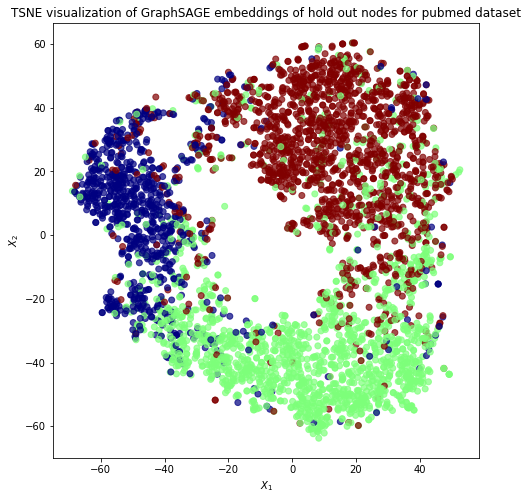

In [41]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings of hold out nodes for pubmed dataset".format(
        transform.__name__
    )
)
plt.show()

This notebook demonstrated inductive representation learning and node classification using the GraphSAGE algorithm.

More specifically, the notebook demonstrated how to use the `stellargraph` library to train a GraphSAGE model using one network and then use this trained model to predict node attributes for a different (but similar) network.

Classification accuracy on the latter network was on par with classification accuracy on a set of training network test nodes with hidden labels.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/graphsage-inductive-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/graphsage-inductive-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>